In [1]:
#IPython extension to reload modules before executing user code. If we make any change in function 
# and imoprting it we don't need to restart if we use auto reload 
%load_ext autoreload

# to print in between values as well without print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


#hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import json


# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.metrics import classification_report
from pprint import pprint as pp


# scipy
from scipy.stats import boxcox

# yellowbrick
from yellowbrick.classifier import ROCAUC

# Supporting Functions

In [3]:
# to save pickle file
def save_pkl_model(path,model):
    pickle.dump(model, open(path,'wb'))

In [4]:
# to load
def load_pkl_model(path):
    sc = pickle.load(open(path,'rb'))
    return sc

In [5]:
def preprocess_pipeline_1(test):
   
    # miss_num_imputer = load_pkl_model(missing_num_imputer_path)
    # missing_cat_imputer = load_pkl_model(missing_cat_imputer_path)
    ohe_converter = load_pkl_model(ohe_converter_path)
    num_transformer = load_pkl_model(mms_converter_path)

    # processing numeric
    num_cols = test.select_dtypes(include='number')
    num_column_names = num_cols.columns
    # num_miss_processed = miss_num_imputer.transform(num_cols)
    num_scalled = num_transformer.transform(num_cols)
    num_scalled_df = pd.DataFrame(num_scalled,columns=num_column_names)


    # processing categoric
    cat_cols = test.select_dtypes(include='O')
    # cat_miss_processed = missing_cat_imputer.transform(cat_cols)
    cat_encoded = ohe_converter.transform(cat_cols).toarray()
    cat_encoded_df = pd.DataFrame(cat_encoded,columns=ohe_converter.get_feature_names_out())


    # combine categoric and numeric data and return
    test_processed = pd.concat([num_scalled_df,cat_encoded_df],axis=1)
    
    return test_processed

In [6]:
def func_dropCol(df,column_elimination = ['SectionID',
                   'StageID',
                  'Semester']):
    for i in column_elimination:
        df = df[df.columns.drop(list(df.filter(regex=i)))]
    return df

In [16]:
# load the json to convert from num to lable
with open('Data/processing_models/num_to_label.json') as json_file:
    num_to_label = json.load(json_file)

with open('Data/processing_models/label_to_num.json') as json_file:
    label_to_num = json.load(json_file)

num_to_label,label_to_num

({'0': 'H', '1': 'L', '2': 'M'}, {'H': 0, 'L': 1, 'M': 2})

# Test and Analysis

## Load and Predict

In [17]:
# spacify saved preprocessing model paths
# missing_num_imputer_path = 'Data/processing_models/imputer_num.pkl'
# missing_cat_imputer_path = 'Data/processing_models/imputer_cat.pkl'
ohe_converter_path = 'Data/processing_models/ohe_converter.pkl'
mms_converter_path = 'Data/processing_models/mms_converter.pkl'

# Specify final ML model path
final_model_path = 'models/random_forest.pkl'


In [18]:
# load test data and check
test_data = pd.read_csv('Data/test.csv')
test_data.head()

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,F,Jordan,Jordan,lowerlevel,G-02,A,French,S,Mum,25,80,29,23,No,Good,Under-7,M
1,M,KW,KuwaIT,MiddleSchool,G-07,A,Math,F,Father,11,2,2,8,No,Bad,Under-7,L
2,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,50,7,9,50,Yes,Bad,Above-7,M
3,M,Jordan,Jordan,MiddleSchool,G-06,A,English,F,Father,10,8,10,10,Yes,Bad,Above-7,M
4,M,Iraq,Iraq,MiddleSchool,G-06,A,English,F,Mum,74,71,56,37,No,Good,Under-7,H


In [19]:
# devide Xtest ytest to compare
X_test,y_test = test_data.loc[:,~test_data.columns.isin(['Class'])],test_data['Class']

In [20]:
# preporcess the data for the model input
X_test_processed = preprocess_pipeline_1(X_test)
X_test_processed.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Semester_S,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,0.25,0.808081,0.295918,0.224490,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,0.11,0.020202,0.020408,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.070707,0.091837,0.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.10,0.080808,0.102041,0.091837,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.74,0.717172,0.571429,0.367347,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [21]:
# drop features not used
X_test_processed = func_dropCol(X_test_processed)
X_test_processed.head()

,raisedhands,VisITedResources,AnnouncementsView,Discussion,gender_M,NationalITy_Iran,NationalITy_Iraq,NationalITy_Jordan,NationalITy_KW,NationalITy_Lybia,...,Topic_History,Topic_IT,Topic_Math,Topic_Quran,Topic_Science,Topic_Spanish,Relation_Mum,ParentAnsweringSurvey_Yes,ParentschoolSatisfaction_Good,StudentAbsenceDays_Under-7
0,0.25,0.808081,0.295918,0.224490,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1,0.11,0.020202,0.020408,0.071429,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.50,0.070707,0.091837,0.500000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.10,0.080808,0.102041,0.091837,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.74,0.717172,0.571429,0.367347,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


In [22]:
# load the final model
final_model = load_pkl_model(final_model_path)

In [23]:
# prefict the model
y_pred = final_model.predict(X_test_processed)
y_pred

array([0, 1, 1, 1, 0, 0, 2, 0, 2, 1, 2, 2, 1, 2, 1, 1, 0, 2, 2, 0, 1, 1,
       2, 0, 2, 0, 0, 1, 2, 1, 2, 0, 0, 1, 2, 0, 1, 1, 2, 2, 0, 1, 2, 0,
       1, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 1, 1, 0, 2, 1, 0, 1,
       0, 2, 1, 0, 1, 1])

In [24]:
predicted_prob = pd.DataFrame(final_model.predict_proba(X_test_processed),columns = [num_to_label[str(i)] for i in final_model.classes_])
predicted_prob.head()

,H,L,M
0,0.538,0.016,0.446
1,0.016,0.762,0.222
2,0.058,0.626,0.316
3,0.082,0.584,0.334
4,0.802,0.010,0.188


In [25]:
y_pred = [num_to_label[str(i)] for i in y_pred]

## Prediction Analysis

### a. Classification Report

In [26]:
# pp(classification_report(y_test,y_pred))
report = classification_report(y_test,y_pred,output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
H,0.800000,0.761905,0.780488,21.000000
L,0.760000,1.000000,0.863636,19.000000
M,0.814815,0.687500,0.745763,32.000000
accuracy,0.791667,0.791667,0.791667,0.791667
macro avg,0.791605,0.816468,0.796629,72.000000
weighted avg,0.796029,0.791667,0.786996,72.000000


### b. Confusion metrics

In [27]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred,labels=['L','M','H'])
cm

array([[19,  0,  0],
       [ 6, 22,  4],
       [ 0,  5, 16]])

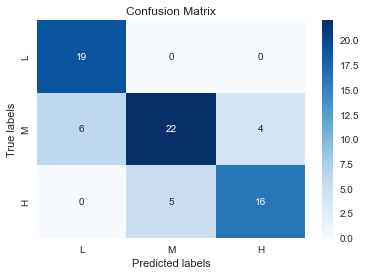

In [28]:
# sn.heatmap(cm, annot=True, cmap='Blues',xticklabels=['L','M','H'],yticklabels=['L','M','H'])

# plotting the values
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='d', ax=ax,cmap='Blues')  

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['L','M','H']); ax.yaxis.set_ticklabels(['L','M','H']);

### ROC AUC curve

In [29]:
training_data = pd.read_csv('Data/transformed/train_mms_ohe.csv')
training_data['Class'] = training_data['Class'].apply(lambda x: label_to_num[x])
X_train,y_train = training_data.iloc[:,:-1],training_data.iloc[:,-1:]

In [30]:
def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model)
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

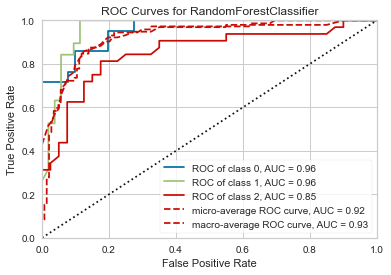

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       estimator=RandomForestClassifier(max_features=5, n_estimators=500,
                                        random_state=1))

In [31]:
plot_ROC_curve(final_model,X_train,y_train,X_test_processed,y_test)

### Save Test Results

In [32]:
test_data['predictions'] = y_pred
test_data = test_data.join(predicted_prob[['L','M','H']])
test_data.to_csv('test_results/test_pred_random_forest.csv',index=False)

### Wrong predictions

In [33]:
test_data[test_data['Class']!=test_data['predictions']]

,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,...,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class,predictions,L,M,H
0,F,Jordan,Jordan,lowerlevel,G-02,A,French,S,Mum,25,...,29,23,No,Good,Under-7,M,H,0.016,0.446,0.538
2,M,KW,KuwaIT,lowerlevel,G-02,B,IT,F,Father,50,...,9,50,Yes,Bad,Above-7,M,L,0.626,0.316,0.058
3,M,Jordan,Jordan,MiddleSchool,G-06,A,English,F,Father,10,...,10,10,Yes,Bad,Above-7,M,L,0.584,0.334,0.082
8,M,KW,KuwaIT,lowerlevel,G-02,B,French,S,Mum,60,...,23,33,Yes,Good,Under-7,H,M,0.034,0.610,0.356
21,M,SaudiArabia,SaudiArabia,lowerlevel,G-02,B,IT,F,Father,7,...,5,3,No,Bad,Above-7,M,L,0.880,0.056,0.064
23,F,Jordan,Jordan,MiddleSchool,G-06,A,English,F,Mum,70,...,42,32,No,Bad,Under-7,M,H,0.022,0.466,0.512
29,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,...,12,50,No,Bad,Above-7,M,L,0.618,0.360,0.022
30,F,KW,KuwaIT,MiddleSchool,G-06,A,Science,S,Father,80,...,62,77,Yes,Good,Under-7,H,M,0.008,0.520,0.472
46,M,KW,KuwaIT,lowerlevel,G-02,B,French,S,Father,40,...,83,33,Yes,Good,Under-7,H,M,0.014,0.664,0.322
51,F,Palestine,Jordan,lowerlevel,G-02,A,Arabic,S,Mum,75,...,51,34,No,Good,Under-7,H,M,0.004,0.528,0.468


In [34]:
# results where model is confident but is wrong
test_data.iloc[[21,52]].iloc[:,8:]

,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class,predictions,L,M,H
21,Father,7,12,5,3,No,Bad,Above-7,M,L,0.880,0.056,0.064
52,Father,0,12,3,3,Yes,Good,Above-7,M,L,0.936,0.032,0.032


# Final Conclution 
1. In general the model is performing well on Lower and Higher classes
2. The data is less to distinguish medium classes from the rest two (as it is observed from ROC-AUC curver as well)